# Проект "Анализ убытков приложения ProcrastinatePRO+"

## Описание проекта

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.


<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера:</b> Отлично, что ты оставила краткое описание проекта в начале, с заголовком и описанием цели. Это помогает читающему быстро соориентироваться, зачем и для чего исследование
</div>

## Изучение общей информации

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Посмотрим на данные

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


**Вывод**

Итак, у нас 3 датасета.

• Таблица **visits** содержит информацию о посещениях сайта.\ 
`User Id` — уникальный идентификатор пользователя\
`Region` — страна пользователя\
`Device` — тип устройства пользователя\
`Channel` — идентификатор источника перехода\
`Session Start` — дата и время начала сессии\
`Session End` — дата и время окончания сессии

• Таблица **orders** хранит информацию о покупках.\
`User Id` — уникальный идентификатор пользователя\
`Event Dt` — дата и время покупки\
`Revenue` — сумма заказа

• В таблице **costs** хранится информация о расходах на рекламу.\
`Channel` — идентификатор рекламного источника\
`Dt` — дата проведения рекламной кампании\
`Costs` — расходы на эту кампанию.

В таблицах нет пропусков. Названия колонок надо привести в "змеиный" регистр. Все колонки с датами имеют тип **object**, надо привести все колонки с датами к типу **datetime64**. И также проверим таблицы на дубликаты.

## Предобработка данных

**1.Приведем все названия колонок к нормальному виду.**

In [9]:
visits.columns = [col.lower().replace(' ','_') for col in visits.columns]
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [10]:
orders.columns = [col.lower().replace(' ','_') for col in orders.columns]
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [11]:
costs.columns = [col.lower() for col in costs.columns]
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

**2.Приведем все даты к нужному типу.**

In [12]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


**3.Проверим на явные дубликаты**

In [16]:
visits.duplicated().sum()

0

In [17]:
orders.duplicated().sum()

0

In [18]:
costs.duplicated().sum()

0

**4.Проверим на неявные дупликаты колонки device, region и channel в таблице visits.**

In [19]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [20]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [21]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

Все хорошо, дубликатов нет

**Вывод**

Итак, все проблемы, которые были в данных, мы устранили. Можно двигаться дальше.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

**ФУНКЦИЯ ДЛЯ СОЗДАНИЯ ПОЛЬЗОВАТЕЛЬСКИХ ПРОФИЛЕЙ**

In [22]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] =  pd.to_datetime(profiles['first_ts'].dt.date, format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


Итак,мы написали функцию, которая возвращает уникальных пользователей, дату их первой сессии, регион, канал перехода на сайт, с какого устройства пользователь заходил, а также САС.

**ФУНКЦИЯ РАСЧЕТА УДЕРЖАНИЯ (RETENTION RATE)**

In [23]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


Функция расчета удержания возвращает таблицу "сырых данных", таблицу удержания и таблицу динамики удержания.

**ФУНКЦИЯ РАСЧЕТА КОНВЕРСИИ**

In [24]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


Функция расчета конверсии возвращает "сырые данные", таблицу конверсии и таблицу динамики конверсии.

**ФУНКЦИЯ РАСЧЕТА LTV И ROI**

In [25]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 


Функция **get_ltv** возвращает не только таблицу LTV, но и таблицу динамики LTV, а такжетаблицу ROI и таблицу динамики ROI. Получив нужные таблицы, благодаря выше написанным функциям, по их данным можно строить графики.

Создадим также функции для визуализации этих показателей.

**ФУНКЦИЯ ДЛЯ ВИЗУАЛИЗАЦИИ УДЕРЖАНИЯ RETENTION RATE**

In [26]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 


In [27]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 


Функция для визуализации Retention Rate возвращает 4 графика: кривые удержания платящих пользователей, кривые удержания неплатящих пользователей, график динамики удержания платящих и график динамики удержания неплатящих пользователей.

**ФУНКЦИЯ ДЛЯ ВИЗУАЛИЗАЦИИ КОНВЕРСИИ**

In [28]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


Функция возвращает 2 графика: кривые конверсии пользователей и динамика конверсии.

**ФУНКЦИЯ ДЛЯ ВИЗУАЛИЗАЦИИ ПОЖИЗНЕННОЙ ЦЕННОСТИ И ОКУПАЕМОСТИ**

In [29]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


Функция возвращает 5 графиков: кривые ltv, динамика ltv, динамика cac, кривые roi и динамика roi.

## Исследовательский анализ данных

**Построим профили пользователей, воспользуясь функцией get_profiles, и найдем минимальную и максимальную дату привлечения.**

In [30]:
profiles = get_profiles(visits, orders,costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [31]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  datetime64[ns]
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 10.4+ MB


**Найдем минимальную и максимальную даты привлечения**

In [32]:
min_date = profiles['dt'].min()
min_date

Timestamp('2019-05-01 00:00:00')

In [33]:
max_date = profiles['dt'].max()
max_date

Timestamp('2019-10-27 00:00:00')

**Вывод**

В таблице **profiles** приведены данные с 01.05.2019 по 27.10.2019г.

**Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.**

In [34]:
users_country = profiles.groupby('region')\
                       .agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
users_country.columns = ['total_users', 'payers_amount', 'payers_share_%']
users_country['payers_share_%'] = round((users_country['payers_share_%'] * 100),2)
users_country.sort_values(by='payers_share_%',ascending=False)

,total_users,payers_amount,payers_share_%
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80


**Вывод**

Итак, больше всего платящих пользователей приходится на США, самая маленькая доля - у Франции.

**Выясним, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.**

In [35]:
users_gevice = profiles.groupby('device')\
                       .agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
users_gevice.columns = ['total_users', 'payers_amount', 'payers_share_%']
users_gevice['payers_share_%'] = round((users_gevice['payers_share_%'] * 100),2)
users_gevice.sort_values(by='payers_share_%',ascending=False)

,total_users,payers_amount,payers_share_%
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


**Вывод**

Чаще всего клиенты пользуются айфонами, но платящие пользователи предпочитают устройства Mac. 

**Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.**

In [36]:
users_channel = profiles.groupby('channel')\
                       .agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
users_channel.columns = ['total_users', 'payers_amount', 'payers_share_%']
users_channel['payers_share_%'] = round((users_channel['payers_share_%'] * 100),2)
users_channel.sort_values(by='payers_share_%',ascending=False)

,total_users,payers_amount,payers_share_%
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


**Вывод**

Посетители чаще всего приходили из источника **organic**, но доля платящих пользователей, пришедших из этого источника, минимальна. Больше всего платящих пользователей пришло из источника **FaceBoom**.

**ОЩИЙ ВЫВОД**

Итак, мы выяснили, что таблице **profiles** приведены данные с 01.05.2019 по 27.10.2019г. Большая часть пользователей приходится на **США**, также в **США** проживает и большая доля платящих пользователей. Клиенты пользуются устройствами **Mac, iPhone, Android и PC**. Но платящие пользователи предпочитают **Mac.** Самый популярный канал среди платящих пользователей - это **FaceBoom**

## Маркетинг

**Посчитаем общую сумму расходов на маркетинг. Также выясним, как траты распределены по источникам и визуализируем изменения метрик во времени.**

Сначала вычислим общую сумму расходов.

In [37]:
round(costs['costs'].sum(),2)

105497.3

Теперь посмотрим, как траты распределены по источникам.

In [38]:
costs.groupby('channel')[['costs']].sum().sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


**Посмотрим, как меняются траты на рекламу во времени.**

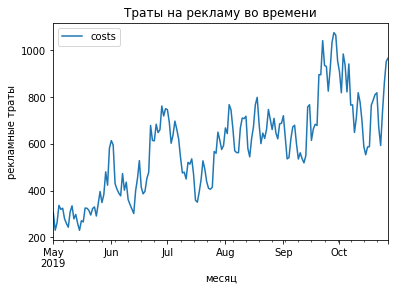

In [39]:
costs.groupby('dt')[['costs']].sum().plot()
plt.title('Траты на рекламу во времени')
plt.xlabel('месяц')
plt.ylabel('рекламные траты');

****Посмотрим, как меняются траты на рекламу во времени в разбивке по каналам.****

<Figure size 2160x720 with 0 Axes>

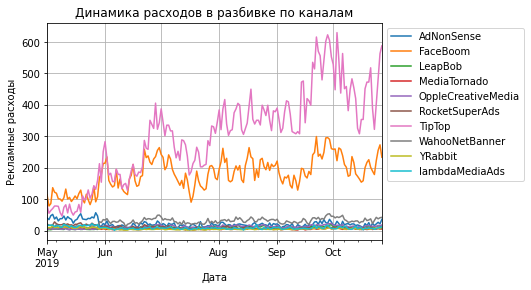

In [40]:
plt.figure(figsize=(30, 10))
costs_by_channel = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
costs_by_channel.plot(grid=True)
plt.xlabel('Дата')
plt.ylabel('Рекламные расходы')
plt.title('Динамика расходов в разбивке по каналам')
plt.legend(bbox_to_anchor=(1, 1));

**Вывод**

Больше всего рекламных затрат приходится на источник **Tip Top** и **FaceBoom**, причем затраты существенные по сравнению с другими источниками. Причем, с течением времени затраты на рекламу только растут, видны существенные скачки вверх в некоторые дни. Расходы на рекламу растут, бизнес несет убытки, значит, реклама не эффективна.

**Рассчитаем средний CAC на одного пользователя для всего проекта.**

Для этого общее количество расходов разделим на количество пользователей, исключив органических пользователей

In [41]:
total_paid_users = profiles.query('channel != "organic"')

In [42]:
round((costs['costs'].sum() / total_paid_users['user_id'].count()),2)

1.13

Итак, в среднем один пользователь обходится фирме в 1.13.

**Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника.**

In [43]:
acq_cost_mean_per_user = (
    profiles.groupby('channel')[['acquisition_cost']]
            .mean()
            .sort_values(by='acquisition_cost', ascending=False)
                        )
acq_cost_mean_per_user['acquisition_cost'] = round(acq_cost_mean_per_user['acquisition_cost'],2)
acq_cost_mean_per_user

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


**Вывод**

Дороже всего обходится привлечение пользователей из источника **TipTop**. Разница по сравнению с другими каналами существенная.

**Выясним, как меняется стоимость привлечения для каждого источника от когорты к когорте.**

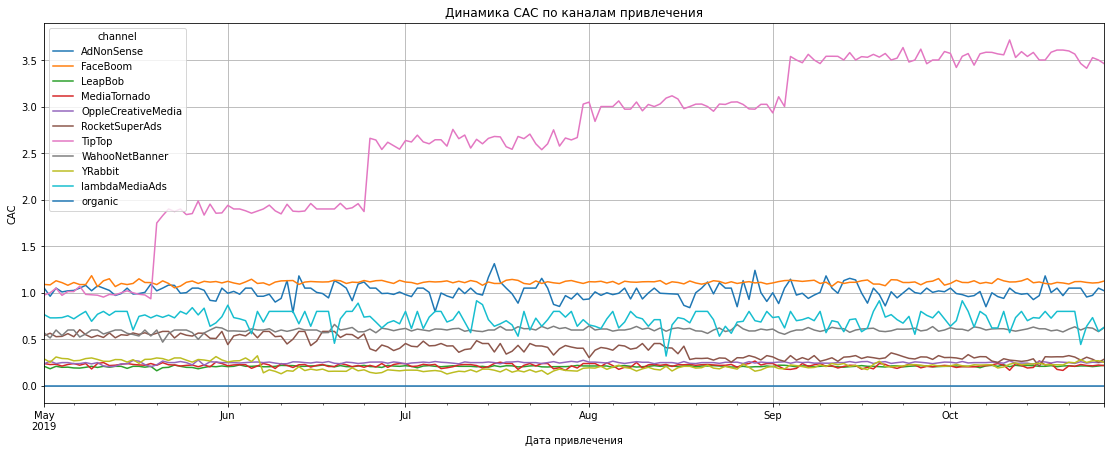

In [44]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(19, 7))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()


**Вывод**

По графику видно, что стоимость привлечения одного клиента из источника **TipTop** растет от месяца к месяцу. Если в мае она составляла примерно 1, то в сентябре и октябре уже около 3,5. Стоимость привлечения пользователей из других источников варьируется примерно от 0.25 до 1$ и остается стабильной на протяжении всего исследуемого периода. 

**ОЩИЙ ВЫВОД**

Итак, общая сумма трат на рекламу составляет 105497.3. В общем, на одного пользователя тратится 1,13. Рекламные расходы увеличиваются от месяца к месяцу, а доходов это не приносит. Самые дорогие каналы - это каналы **TipTop** и **FaceBoom**. Причем расходы на канал **TipTop** растут каждый месяц.

## Оценка окупаемости рекламы для привлечения пользователей


Считаем, что мы смотрим данные 1-го ноября 2019 года и что в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

Итак, зададим момент и горизонт анализа данных 01.11.2019 и 14 дней соответственно. Исключим из анализа органических пользователей, так как они бесплатные,на них рекламный бюджет не тратился.

In [45]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [46]:
profiles_new = profiles.query('channel != "organic"')

### Проанализируем общую окупаемость рекламы

Рассчитаем LTV и ROI. Затем по этим данным построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

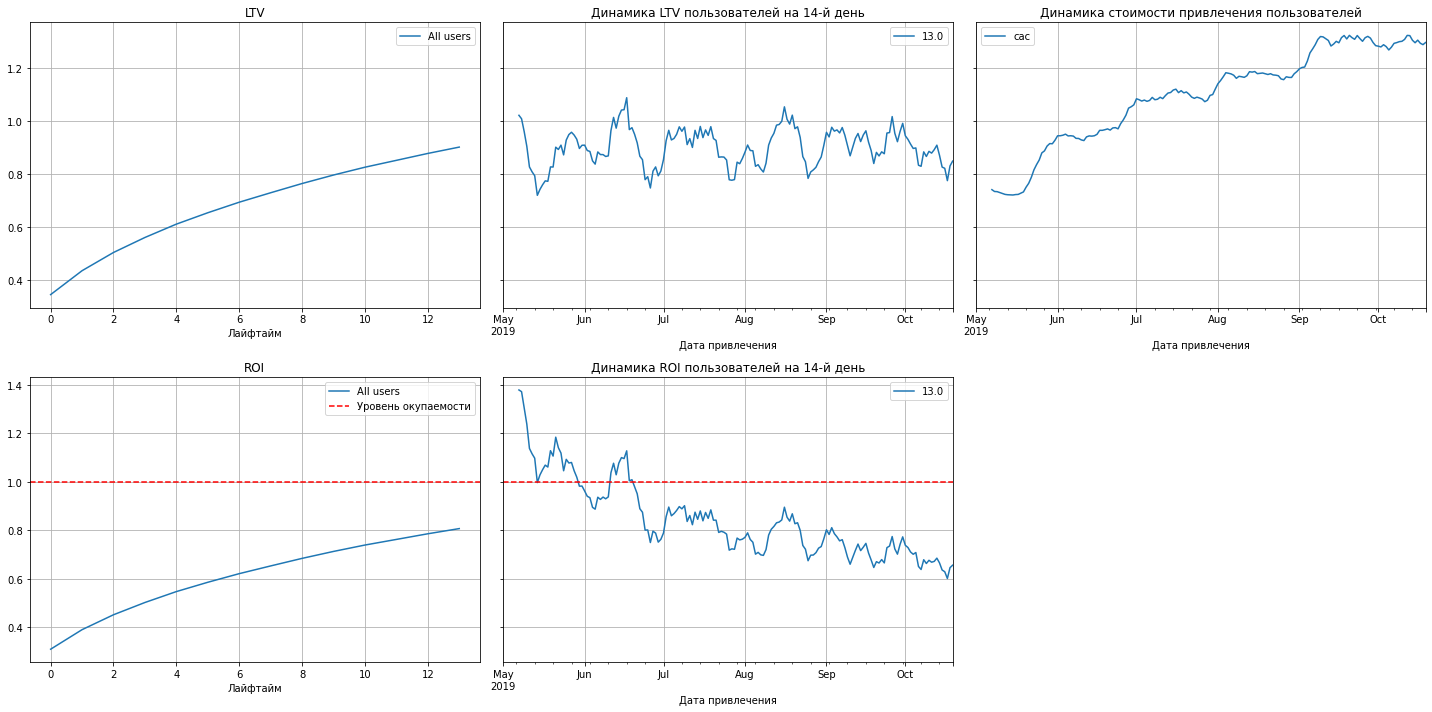

In [47]:
# считаем LTV, CAC и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new,
    orders,
    observation_date,
    horizon_days,
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 
# plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

**Вывод**

Итак, если смотреть в общем, можно сделать такие выводы:
- Реклама не окупается. ROI в конце 2 недели — около 80%.
- CAC не стабилен, растет от месяца к месяцу.
- Динамика ROI на 14 день тоже совсем не стабильна, если в мае реклама окупалась и была около 140 %, то примерно с середины мая этот показатель падал и к октябрю был всего лишь около 60%.
- LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей

Проверим все доступные характеристики пользователей — страна, источник и устройство первого посещения.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

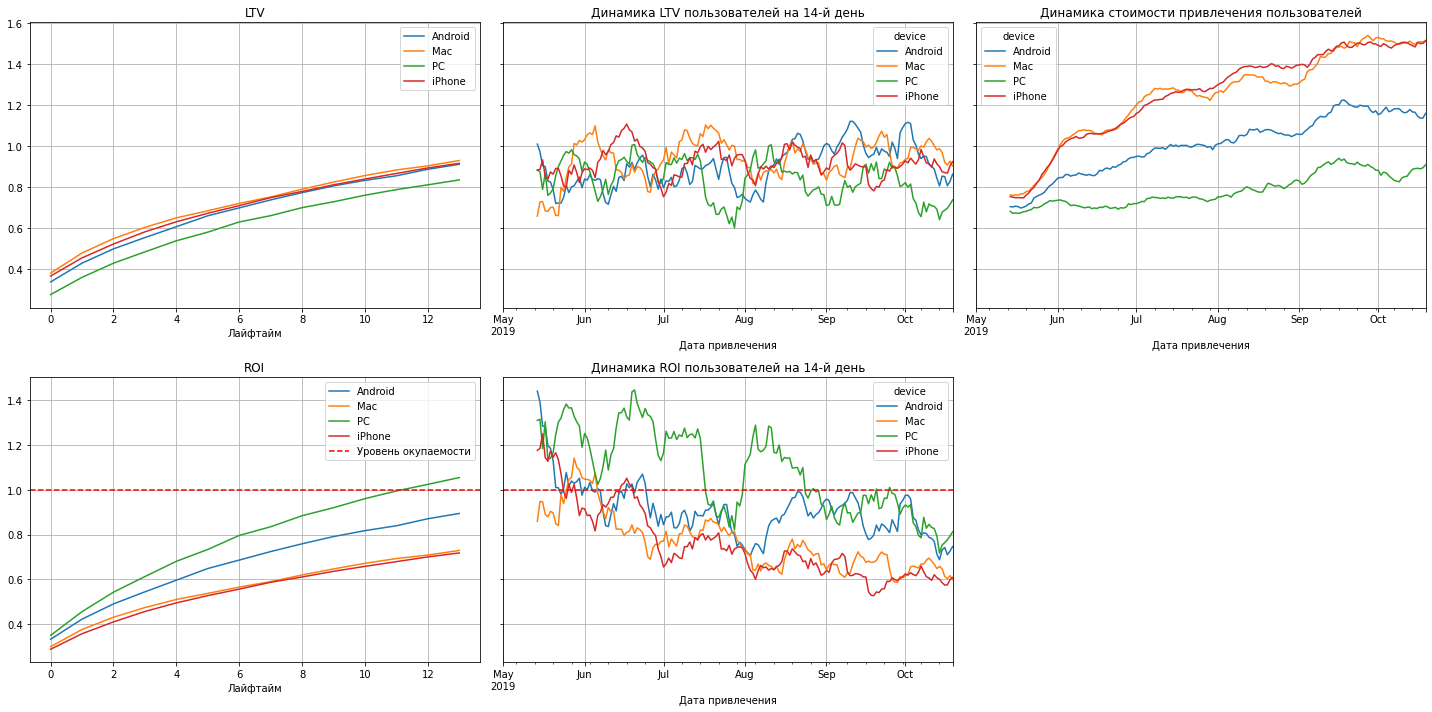

In [48]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**

Итак, мы видим, что пользователи PC окупаются, а вот пользователи Android, Mac и iPhone - нет. Стоимость привлечения на всех устройствах увеличивается от месяца к месяцу, особенно у устройств Mac и iPhone.

### Проанализируем окупаемость рекламы с разбивкой по странам

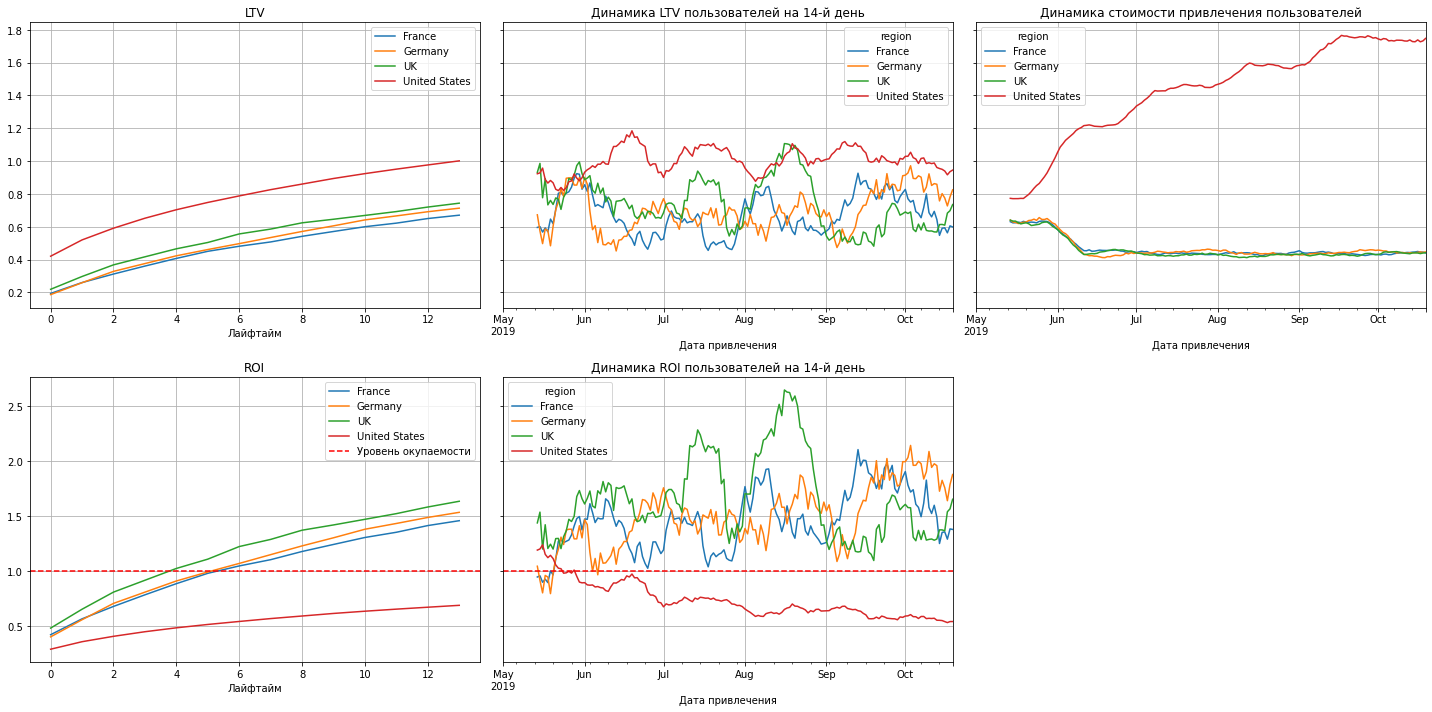

In [49]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**

Итак, мы видим, что США хоть и лидируют по показателю LTV, но вот что касается окупаемости, то реклама в США совсем не окупается, в отличии от других стран.Лучше всего окупается Великобритания. LTV хоть и немного подвержен сезонности, но стабилен. Стоимость привлечения в США растет, в отличии от других стран, где она стабильна и примерно одинакова. Да и динамика ROI пользователей к концу второй недели у США снижается. Теперь понятно, где закралась проблема!

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

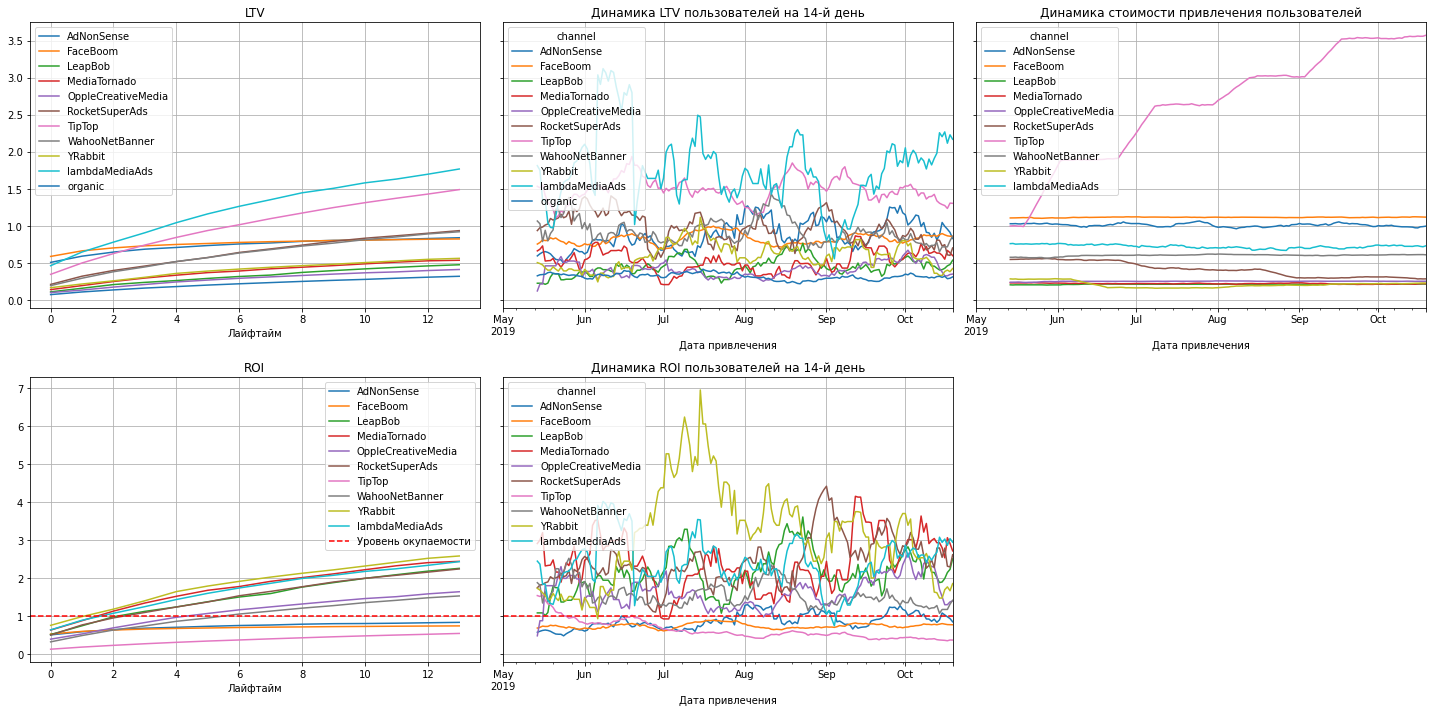

In [50]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**

Итак, судя по графикам окупаются все каналы, кроме трех: **Tip-Top**, **Faceboom**  и **AdNonSense**. Что ни удивительно, по таблице рекламных каналов выше это три канала лидера. Плюс расходы на рекламу канала Tip-Top растут с каждым месяцем.


**Теперь посчитаем конверсию и удержание пользователей из США, а также пользователей, пришедших из каналов Tip-Top, Faceboom  и AdNonSense.** Для этого вызовем функции get_conversion(), plot_conversion(), get_retention() и plot_retention(). Таблицу **profiles** будем использовать уже со всеми пользователями(органическими тоже).

In [51]:
dimensions = ['region']

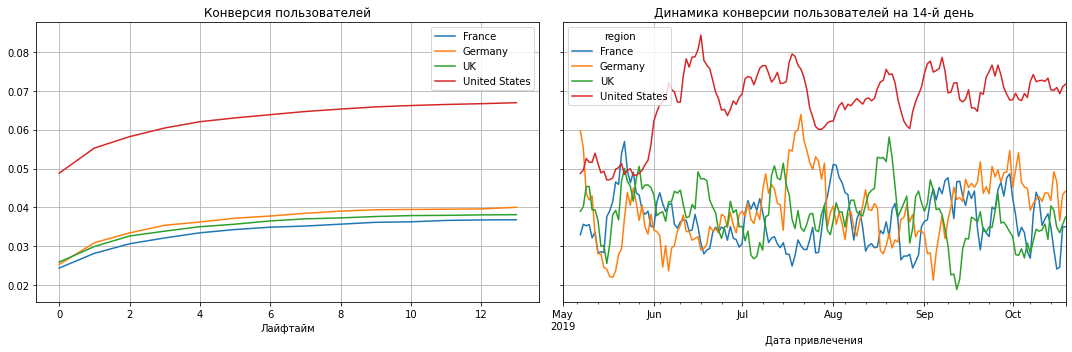

In [52]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


**Вывод**

Что мы видим, конверсия у пользователей США выше, чем у других пользователей. Но вот конвертируются пользователи и в США и в других странах не так хорошо, как хотелось бы. К 12 лайфтайму все пользователи по показателю конверсии выходят в плато. 

**Проверим теперь удержание в разбивке по странам.**

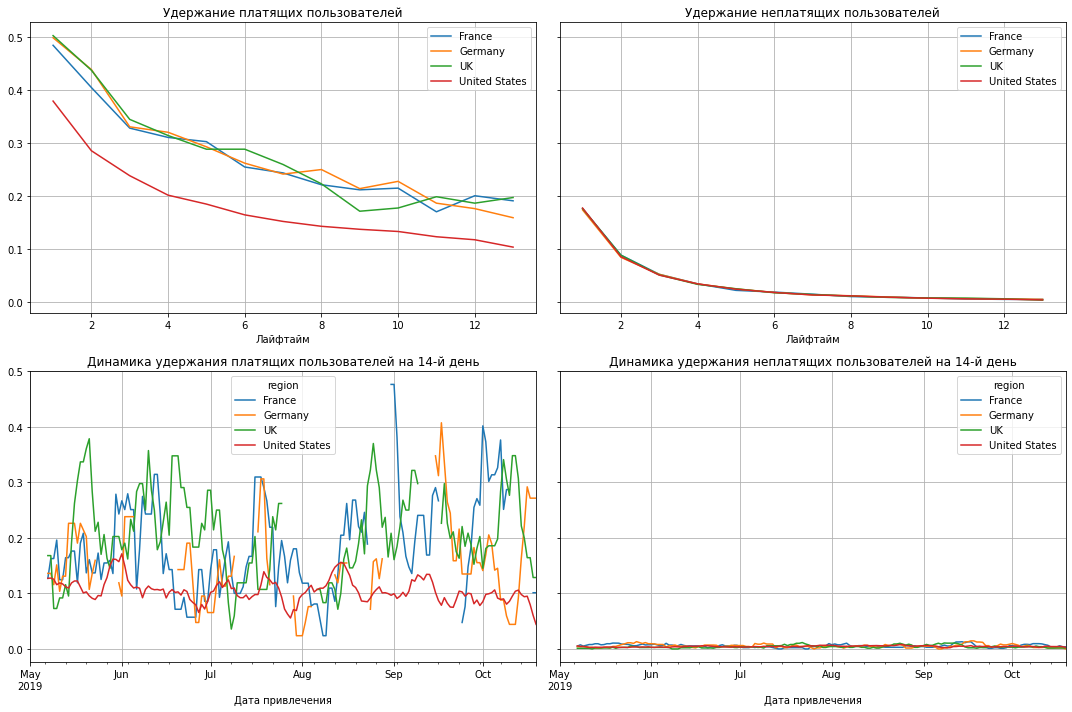

In [53]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 


**Вывод**

Да, видно что с удержанием тоже все не очень хорошо, и у США с этим параметром дела обстоят хуже, чем в остальных странах. При этом, LTV у пользователей США самый большой. Возможно, привлекается много людей, но часто не тех, кто заинтересован в продукте

**Проверим также конверсию и удержание в разбивке по каналам.**

In [54]:
dimensions = ['channel']

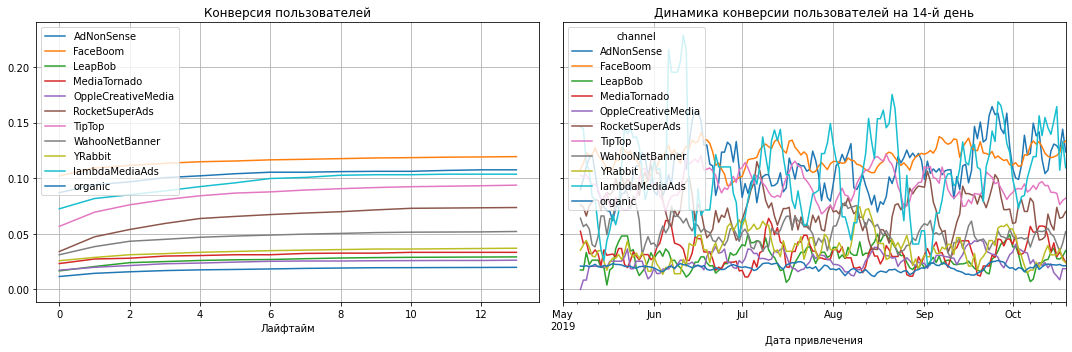

In [55]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

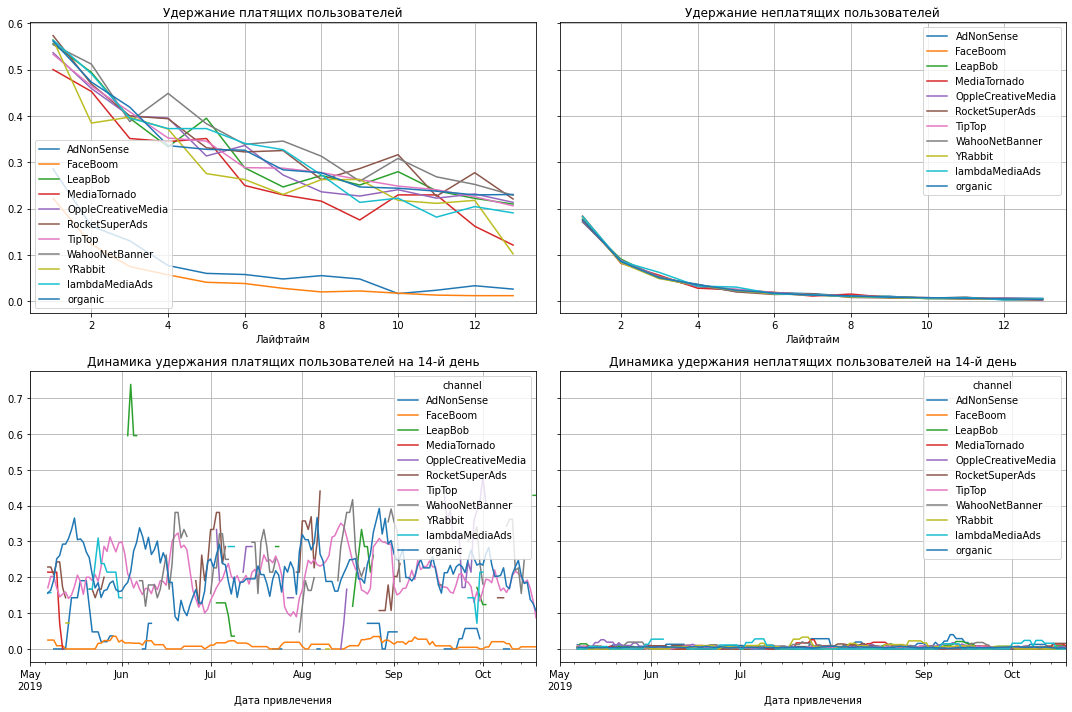

In [56]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**

Конверсия у пользователей из всех источников не очень высока, и также к концу 12 лайфтайма выходит на плато. А вот с удержанием хуже всего дела обстоят у пользователей, пришедших из источника **FaceBoom**. Думаю, есть вероятность, что в работе с некоторыми каналами выбрана неправильная коммуникация или неподходящая настройка ЦА, и рекламная кампания привлекает не тех людей.

**Проверим конверсию и удержание пользователей в разбивке по устройствам.**

In [57]:
dimensions = ['device']

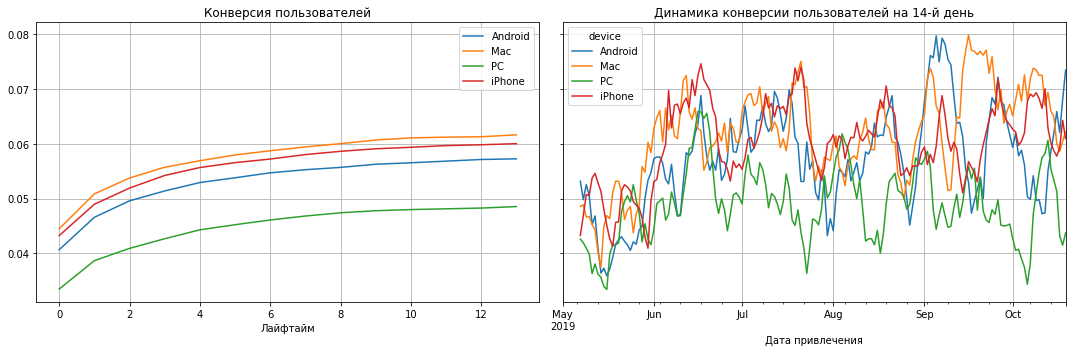

In [58]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

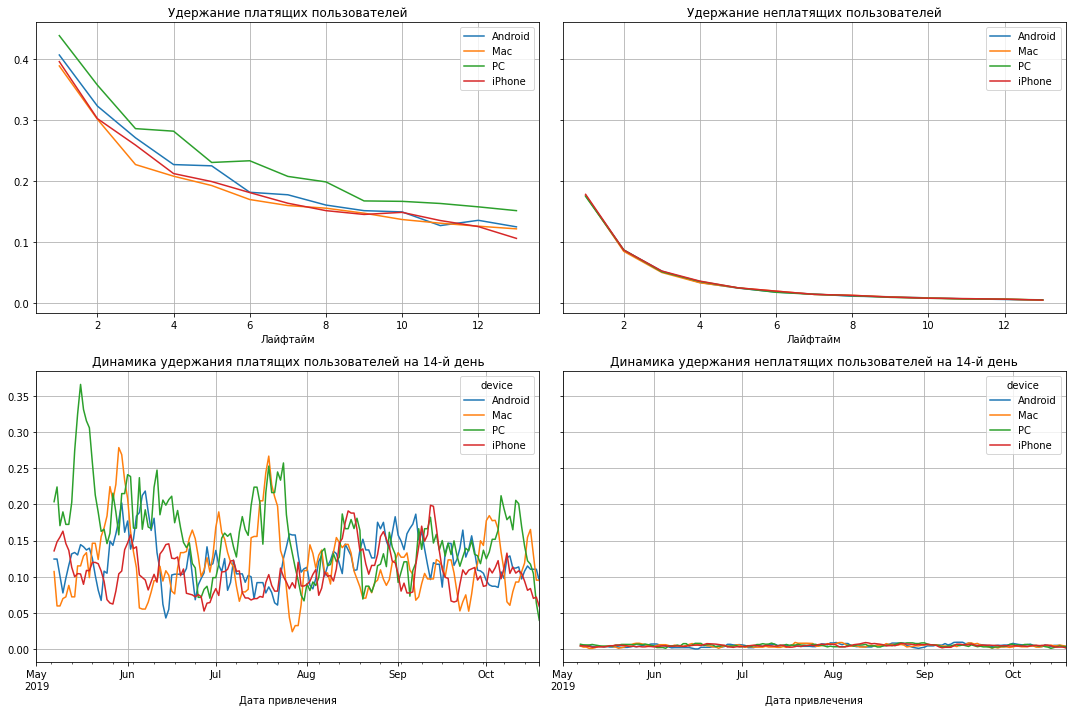

In [59]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**

Конверсия у пользователей с устройством PC немного ниже, чем у остальных устройств. А вот удержание у всех устройств примерно на одном уровне, у PC чуть выше, чем у остальных.

**Посмотрим еще на общую конверсию и удержание**

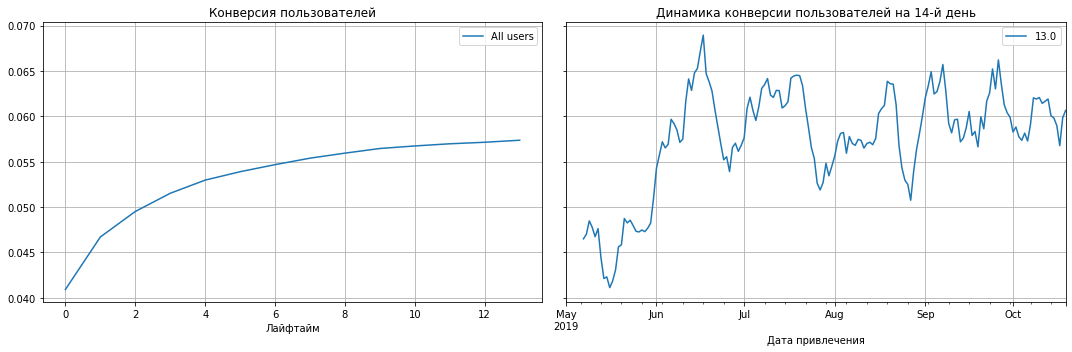

In [60]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 


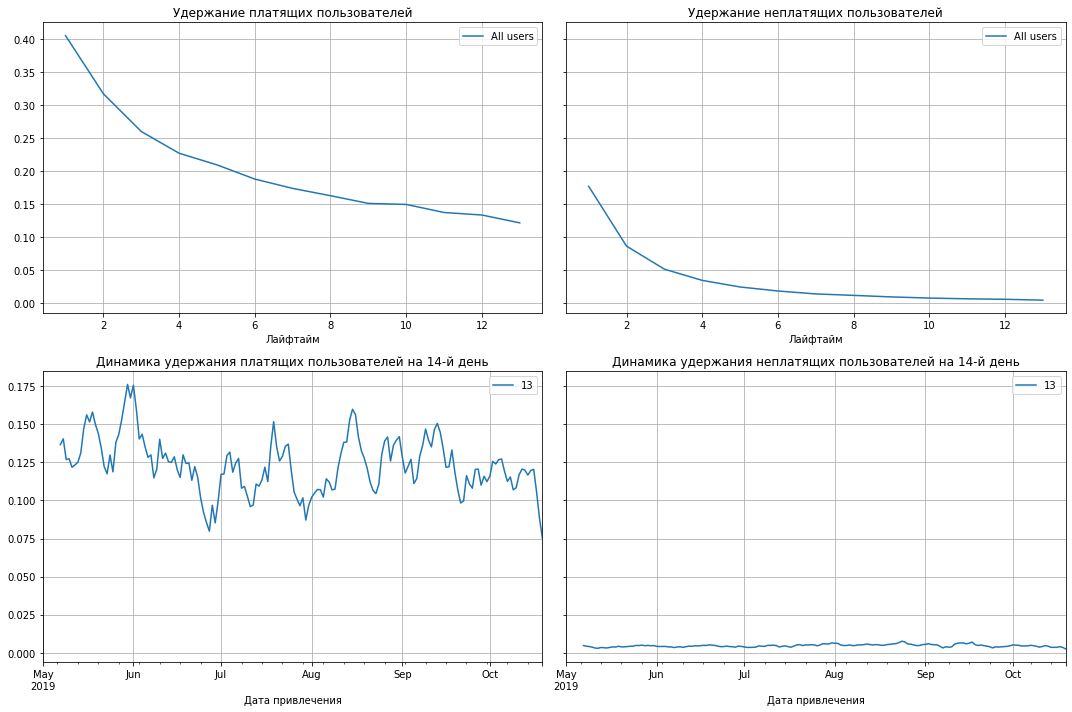

In [61]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 


**Вывод**
Если смотреть в целом, конверсия и удержание достаточно стабильны.

**ОБЩИЙ ВЫВОД**

Итак, что касается окупаемости рекламы. Если смотреть в общем, рекламные расходы не окупаются. При этом, расходы на рекламу растут каждый месяц. LTV пользователей достаточно стабилен.

- В разрезе по устройствам - пользователи PC окупаются, но в динамике ведут себя не так стабильно, как хотелось бы. Пользователи Android, Mac и iPhone не окупаются совсем.
- В разбивке по странам - явный аутсайдер США. Пользователи из США хоть и лидируют по уровню LTV и конверсии, но по рекламным расходам совсем не окупаются. Тогда как пользователи из других стран окупаются уже на 4-5-й день. Также у США хуже, чем у остальных стран, удержание клиентов. 
- В разбивке по каналам - окупаются все каналы, кроме TipTop, FaceBoom и AdNonSense.

## Общий вывод

**Причины неэффективности рекламы**
* Самые дорогостоящие пользователи - это пользователи из США. Стоимость привлечения пользователей из США росла от месяца к месяцу. С мая по октябрь 2019 года стоимость привлечения таких пользователей выросла примерно на 100%. Также, пользователи из США удерживаются хуже, чем в других странах.
* Самые дорогостоящие каналы для рекламы - это каналы **Tip-Top, FaceBoom и AdhonSense**. Эти каналы совсем не окупаются, в отличии от других каналов, пользователи которых окупаются уже на третий день "жизни". Стоимость привлечения одного пользователя из канала **Tip-Top** около 2.80, по сравнению с другими это очень дорого. Так, например, стоимость одного пользователя из канала **MediaTornado** - около 0.21. К тому же расходы на канал **Tip-Top** постоянно росли (в мае стоимость была около 1, а октябрю она была уже около 3.5, то есть выросла больше, чем в 3 раза). А удержание у пользователей из канала **FaceBoom** ниже, чем у других примерно на 20 %.
* Что касается устройств, то проблемные устройства - это **Mac** и **iPhone**. Рекламные расходы на пользователей этих устройств выросли с мая по октябрь примерно на 80%. Пользователи с этими устройствами совсем не окупаются.

**Рекомендации маркетологам**
* Судя по всему, реклама в США совсем не дает нужного результата, расходы на пользователей только увеличиваются.Возможно стоит пересмотреть или что-то изменить в рекламных компаниях в этой стране. Пользователи там хорошо конвертируются, а вот удерживаются плохо. Возможно, надо пересмотреть аудиторию, на которую направлена реклама.
* У нас есть три канала, на которые уходит достаточно ощутимая часть рекламного бюджета, но пользователи из этих каналов совсем не окупаются - **Tip-Top, FaceBoom и AdhonSense**. Может быть, стоит исключить эти дорогостоящие каналы из будущих рекламных расходов. И поискать более дешевые и приносящие "более качественных" пользователей.
* Также можно поработать над конверсией пользователей, этот показатель хоть и растет, но достаточно медленно. Возможно, нужны какие-то акции или другие "плюшки" для пользователей, чтобы улучшить этот показатель.